In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [2]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [3]:
#%%bash
#pip install pytorch-pretrained-bert

In [4]:
seed = 42#default 42
np.random.seed(seed)
random.seed(seed)

In [5]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=7,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=500,
)

In [6]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

In [7]:
device='cuda'
torch.cuda.set_device(2)

In [8]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [9]:
from sklearn.model_selection import train_test_split

DATA_ROOT = Path("") 

train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["task1_trainset.csv", "task1_public_testset.csv"]]

In [10]:
train.drop('Title',axis=1,inplace=True)
train.drop('Categories',axis=1,inplace=True)
train.drop('Created Date',axis=1, inplace=True)
train.drop('Authors',axis=1,inplace=True)
test.drop('Title',axis=1,inplace=True)
test.drop('Categories',axis=1,inplace=True)
test.drop('Created Date',axis=1, inplace=True)
test.drop('Authors',axis=1,inplace=True)

In [11]:
train['BACKGROUND']=0
train['OBJECTIVES']=0
train['METHODS']=0
train['RESULTS']=0
train['CONCLUSIONS']=0
train['OTHERS']=0
for i in range(train.Id.count()):
    string = train['Task 1'][i]
    train['BACKGROUND'][i] = 1 if (string.find('BACKGROUND')!=-1) else 0
    train['OBJECTIVES'][i] = 1 if (string.find('OBJECTIVES')!=-1) else 0
    train['METHODS'][i] = 1 if (string.find('METHODS')!=-1) else 0
    train['RESULTS'][i] = 1 if (string.find('RESULTS')!=-1) else 0
    train['CONCLUSIONS'][i] = 1 if (string.find('CONCLUSIONS')!=-1) else 0
    train['OTHERS'][i] = 1 if (string.find('OTHERS')!=-1) else 0
train.head()

/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/IPL915/.conda/envs/KIWI/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,Id,Abstract,Task 1,BACKGROUND,OBJECTIVES,METHODS,RESULTS,CONCLUSIONS,OTHERS
0,D00001,Rapid popularity of Internet of Things (IoT) a...,BACKGROUND OBJECTIVES METHODS METHODS RESULTS ...,1,1,1,1,1,0
1,D00002,"In this paper, we address the problem of compu...",OBJECTIVES OTHERS METHODS/RESULTS RESULTS RESULTS,0,1,1,1,0,1
2,D00003,High quality upsampling of sparse 3D point clo...,BACKGROUND OBJECTIVES METHODS METHODS METHODS ...,1,1,1,1,1,0
3,D00004,Internet is the main source of information now...,BACKGROUND BACKGROUND BACKGROUND OBJECTIVES OB...,1,1,1,1,1,0
4,D00005,Automated Facial Expression Recognition (FER) ...,BACKGROUND BACKGROUND BACKGROUND BACKGROUND ME...,1,1,1,1,1,0


In [12]:
train.drop('Task 1',axis=1,inplace=True)
train

,Id,Abstract,BACKGROUND,OBJECTIVES,METHODS,RESULTS,CONCLUSIONS,OTHERS
0,D00001,Rapid popularity of Internet of Things (IoT) a...,1,1,1,1,1,0
1,D00002,"In this paper, we address the problem of compu...",0,1,1,1,0,1
2,D00003,High quality upsampling of sparse 3D point clo...,1,1,1,1,1,0
3,D00004,Internet is the main source of information now...,1,1,1,1,1,0
4,D00005,Automated Facial Expression Recognition (FER) ...,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...
6995,D06996,We have witnessed the discovery of many techni...,1,1,1,1,0,0
6996,D06997,State-of-the-art slot filling models for goal-...,1,1,1,1,1,0
6997,D06998,Real-time semantic segmentation plays an impor...,1,1,1,1,1,0
6998,D06999,We propose a neural embedding algorithm called...,0,1,1,1,1,0


In [13]:
train, val = train_test_split(train, shuffle=True, test_size=0.2, random_state=42)

In [14]:
train.head()

,Id,Abstract,BACKGROUND,OBJECTIVES,METHODS,RESULTS,CONCLUSIONS,OTHERS
1032,D01033,"Many computer vision applications, such as obj...",1,1,1,1,1,0
6339,D06340,Many experimental proposals for noisy intermed...,1,1,1,1,1,0
3886,D03887,In the present paper we describe the technolog...,1,1,1,1,1,0
2653,D02654,An important property of programming language ...,1,1,1,1,1,0
6914,D06915,Multilingual topic models enable crosslingual ...,1,1,1,1,1,0


In [15]:
val.head()

,Id,Abstract,BACKGROUND,OBJECTIVES,METHODS,RESULTS,CONCLUSIONS,OTHERS
6500,D06501,In this paper we present the Creative Inventio...,1,1,1,0,0,0
2944,D02945,Computer algorithms are written with the inten...,1,1,1,1,1,0
2024,D02025,The problem of finding the maximum number of v...,1,1,1,0,0,0
263,D00264,Real-world machine learning applications often...,1,0,1,1,0,0
4350,D04351,Typically an ontology matching technique is a ...,1,1,1,1,0,0


In [16]:
test.head()

,Id,Abstract
0,T00001,Mobile Crowdsensing is a promising paradigm fo...
1,T00002,A keyboard has many function keys and each fun...
2,T00003,With increasing availability of communication ...
3,T00004,The clustered planarity problem (c-planarity) ...
4,T00005,We introduce a genetic programming method for ...


In [17]:
if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

In following code snippets, we need to wrap BERT vocab and BERT tokenizer with Fastai modules

In [18]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

In [19]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

In [20]:
label_cols = ["BACKGROUND", "OBJECTIVES", "METHODS", "RESULTS", "CONCLUSIONS", "OTHERS"]

# databunch = TextDataBunch.from_df(".", train, val, test,
#                   tokenizer=fastai_tokenizer,
#                   vocab=fastai_bert_vocab,
#                   include_bos=False,
#                   include_eos=False,
#                   text_cols="comment_text",
#                   label_cols=label_cols,
#                   bs=config.bs,
#                   collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
#              )

Alternatively, we can pass our own list of Preprocessors to the databunch (this is effectively what is happening behind the scenes)

In [21]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

In [22]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In this project, we will be using Databunch which is easier to create and use.

In [23]:
# this will produce a virtually identical databunch to the code above
databunch = BertDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  text_cols="Abstract",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [24]:
databunch.show_batch()

text,target
"[CLS] one mona ##d to prove them all is a modern fairy tale about curiosity and per ##se ##verance , two important properties of a successful phd student . $ $ $ we follow the phd student mona on her adventure of proving properties about has ##kell programs in the proof assistant co ##q . $ $ $ on the one hand , as a phd student in computer science",BACKGROUND;OBJECTIVES;METHODS;RESULTS;CONCLUSIONS;OTHERS
"[CLS] resist ##ive cross ##bar ##s have emerged as promising building blocks for realizing d ##nn ##s due to their ability to compact ##ly and efficiently realize the dominant d ##nn computational kernel , viz . , vector - matrix multiplication . $ $ $ however , a key challenge with resist ##ive cross ##bar ##s is that they suffer from a range of device and circuit level non -",BACKGROUND;OBJECTIVES;METHODS;RESULTS;CONCLUSIONS;OTHERS
"[CLS] unlike its deter ##mini ##stic counterpart , static and st ##och ##astic vehicle routing problems ( ss - vr ##p ) aim at modeling and solving real - life operational problems by considering uncertainty on data . $ $ $ we consider the ss - vr ##pt ##w - cr introduced in saint - gui ##lla ##in et al . $ $ $ ( 2017 ) . $ $",BACKGROUND;OBJECTIVES;METHODS;RESULTS;CONCLUSIONS;OTHERS
"[CLS] remote sensing image classification is a fundamental task in remote sensing image processing . $ $ $ remote sensing field still lacks of such a large - scale bench ##mark compared to image ##net , place ##2 . $ $ $ we propose a remote sensing image classification bench ##mark ( rs ##i - cb ) based on crowd - source data which is massive , scala ##ble ,",BACKGROUND;OBJECTIVES;METHODS;RESULTS;CONCLUSIONS
[CLS] the constrained cramer - rao bound ( cc ##rb ) is a lower bound on the mean - squared - error ( ms ##e ) of est ##ima ##tors that satisfy some un ##bia ##sed ##ness conditions . $ $ $ although the cc ##rb un ##bia ##sed ##ness conditions are satisfied as ##ym ##pt ##otic ##ally by the constrained maximum likelihood ( cm ##l ) est ##ima ##tor,BACKGROUND;OBJECTIVES;METHODS;RESULTS;CONCLUSIONS


# Model

In [25]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=6)

In [26]:
loss_func = nn.BCEWithLogitsLoss()

In [27]:
from fastai.callbacks import *

learner = Learner(
    databunch, bert_model,
    loss_func=loss_func,
)
if config.use_fp16: learner = learner.to_fp16()

In [28]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


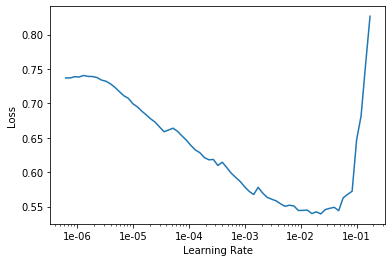

In [29]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,time


In [ ]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [ ]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [ ]:
sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")
if config.testing: sample_submission = sample_submission.head(test.shape[0])
sample_submission[label_cols] = test_preds
sample_submission.to_csv("bert_with _fastai_predictions.csv", index=False)